In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import *
from torchvision import datasets
from torchvision.transforms import *

In [2]:
# Download MNIST dataset
full_dataset = datasets.MNIST(
    root="data",
    download=True,
    transform=ToTensor(),
)

dataset_size = len(full_dataset)

# Split the dataset
train_dataset, validation_dataset, test_dataset = random_split(
    full_dataset, [int(0.7*dataset_size),
                   int(0.15*dataset_size),
                   int(0.15*dataset_size)]
)

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader      = DataLoader(train_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader       = DataLoader(test_dataset, batch_size=batch_size)

# DELME
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


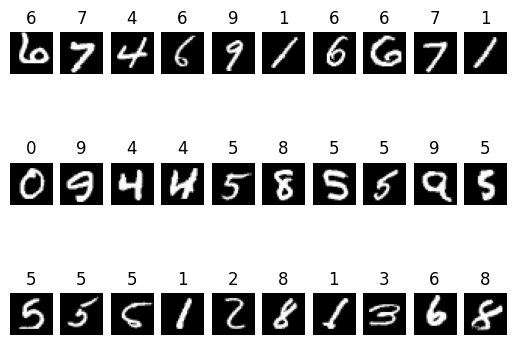

In [40]:
# Show some examples of the dataset

(fig,ax) = plt.subplots(3, 10)
for i,ds in enumerate([train_dataset, validation_dataset, test_dataset]):
    for j in range(10):
        ax[i,j].imshow(ds[j][0][0], cmap="gray")
        ax[i,j].set_axis_off()
        ax[i,j].set_title(ds[j][1])
plt.axis('off')
plt.show()

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [14]:
# Define model
class ClassicMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
import torch.nn.functional as F

class SmallMNISTCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
#model = ClassicMNIST().to(device)
model = SmallMNISTCNN().to(device)
print(model)

SmallMNISTCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [24]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    print("Validation: ", end="")
    test(validation_dataloader, model, loss_fn)
    print("Test: ", end="")
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.328304  [   64/42000]
loss: 2.025168  [ 6464/42000]
loss: 1.814765  [12864/42000]
loss: 1.492264  [19264/42000]
loss: 1.223464  [25664/42000]
loss: 1.081259  [32064/42000]
loss: 0.995929  [38464/42000]
Validation: Accuracy: 87.2%, Avg loss: 0.844646
Test: Accuracy: 87.0%, Avg loss: 0.843698
Epoch 2
-------------------------------
loss: 0.820360  [   64/42000]
loss: 0.728095  [ 6464/42000]
loss: 0.822111  [12864/42000]
loss: 0.578733  [19264/42000]
loss: 0.545833  [25664/42000]
loss: 0.532458  [32064/42000]
loss: 0.546096  [38464/42000]
Validation: Accuracy: 91.8%, Avg loss: 0.437988
Test: Accuracy: 91.5%, Avg loss: 0.438509
Epoch 3
-------------------------------
loss: 0.393963  [   64/42000]
loss: 0.435153  [ 6464/42000]
loss: 0.498890  [12864/42000]
loss: 0.377107  [19264/42000]
loss: 0.383247  [25664/42000]
loss: 0.333933  [32064/42000]
loss: 0.444125  [38464/42000]
Validation: Accuracy: 93.5%, Avg loss: 0.307209
Test: Accuracy: 93.2%,

In [23]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

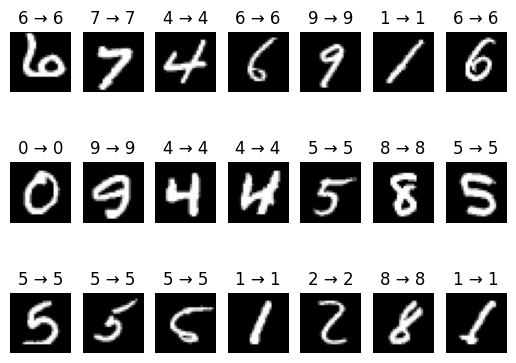

In [44]:
# Show some examples of the dataset

model.eval()
(fig,ax) = plt.subplots(3, 7)
for i,ds in enumerate([train_dataset, validation_dataset, test_dataset]):
    for j in range(7):
        x, y_gt = ds[j]
        x = x[None,:].to(device)
        y_out = model(x)
        pred = y_out[0].argmax(0)
        
        ax[i,j].imshow(ds[j][0][0], cmap="gray")
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f"{y_gt} → {int(pred)}")
plt.axis('off')
plt.show()